In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
# import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict, Counter
import random
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.utils.data import WeightedRandomSampler
from sklearn.cluster import MiniBatchKMeans
import itertools
import os
from math import ceil

# VQVAE Implementation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("pkl files/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

# with open("/content/drive/MyDrive/chunks.pkl", "rb") as f:
#     chunks = pickle.load(f)

In [ ]:
# Importing models
from vqmodel import *

In [ ]:
# Dataframe to tensor transition
images = []

for df in chunks:
    # df['ch'] is a Series of 80 columns; each item is a list of 200 values
    # Create a (200, 80) NumPy array (transpose is needed)
    matrix = np.stack(df['PWR_ch1'].to_list(), axis=1)  # shape: (200, 80)
    images.append(matrix)

# Convert the whole thing to numpy because making tensors from a list of arrays
# is extremely slow
images_array = np.array(images)


In [6]:
# Convert to torch tensor and add batch + channel dimensions
data_tensor = torch.tensor(images_array, dtype=torch.float32)  # (B, 200, 80)
data_tensor = data_tensor.unsqueeze(1)  # (B, 1, 200, 80)

In [7]:
from torch.utils.data import DataLoader

dataset = ChunkImageDataset(chunks)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE(in_channels=1)

for batch in loader:
    print(batch.shape)  # (8, 1, 200, 80)
    outputs = model(batch)
    break  # for test

torch.Size([8, 1, 200, 30])


In [8]:
from sklearn.model_selection import train_test_split

# 1. First split: 80% train, 20% temp
train_chunks, temp_chunks = train_test_split(
    chunks, test_size=0.2, random_state=2555304
)

In [9]:
# 2. Split temp into 10% val, 10% test
val_chunks, test_chunks = train_test_split(
    temp_chunks, test_size=0.5, random_state=2555304
)

In [10]:
# Check counts
print(f"Train: {len(train_chunks)}")
print(f"Validation: {len(val_chunks)}")
print(f"Test: {len(test_chunks)}")

Train: 5147
Validation: 643
Test: 644


In [11]:
# 1) Datasets
train_dataset = ChunkImageDataset(train_chunks)  # expects __len__/__getitem__
val_dataset   = ChunkImageDataset(val_chunks)
test_dataset  = ChunkImageDataset(test_chunks)

# 2) Get labels aligned to *train_dataset*
# Prefer: expose labels from dataset
if hasattr(train_dataset, "labels"):
    train_labels = list(train_dataset.labels)  # len == len(train_dataset)
# Fallback: extract from stored chunks inside dataset
elif hasattr(train_dataset, "chunks"):
    train_labels = [df["activity"].iat[0] for df in train_dataset.chunks]
else:
    # Last resort: rebuild from the split source you used
    train_labels = [df["activity"].iat[0] for df in train_chunks]

assert len(train_labels) == len(train_dataset), "Label count must match train_dataset length."

# 3) Class-balanced sampler for train
cnt = Counter(train_labels)
# equal target per class (optionally downweight 'noactivity' here)
target = {c: 1.0 for c in cnt.keys()}
# e.g., target["noactivity"] = 0.5

weights = torch.tensor([target[l] / cnt[l] for l in train_labels], dtype=torch.float)
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_labels), replacement=True)

# 4) DataLoaders
# NOTE: do not set shuffle=True when using a sampler.
train_loader = DataLoader(
    train_dataset, batch_size=64, sampler=train_sampler,
    drop_last=True, num_workers=4, pin_memory=True
)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# 5) Sanity checks
print("len(train_dataset) =", len(train_dataset))
print("len(train_labels)  =", len(train_labels))
print("classes & counts   =", dict(cnt))

len(train_dataset) = 5147
len(train_labels)  = 5147
classes & counts   = {np.str_('noactivity'): 3241, np.str_('walk'): 919, np.str_('sit'): 46, np.str_('bodyrotate'): 615, np.str_('stand'): 30, np.str_('liedown'): 154, np.str_('standfromlie'): 142}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Model Training

In [12]:
def train_vqvae(model, train_loader, val_loader, optimizer, device="cuda", epochs=100,
                beta_start=0.1, beta_end=None, warmup_epochs=2, ramp_epochs=5,
                noise_std=0.0, cooldown_frac=0.7, lambda_align=0.03):

    os.makedirs("output_images", exist_ok=True)
    model.to(device)

    # final target beta from ctor if not provided
    if beta_end is None:
        beta_end = float(model.quantizer.beta)

    # histories
    train_losses, val_losses = [], []
    recon_losses, vq_losses = [], []
    cm_losses, code_usages, zq_stds, perplexities = [], [], [], []

    # helpers
    def pool(z):  # z: [B,C,H,W] -> [B,2C] using mean+std
        m = z.mean((2,3))
        s = z.std((2,3))
        return torch.cat([m, s], dim=1)

    cooldown_at = int(epochs * cooldown_frac)
    K = getattr(model.quantizer, "num_embeddings", None)

    for epoch in range(1, epochs + 1):
        # ---- beta schedule + quantize gate ----
        if epoch <= warmup_epochs:
            beta_now = beta_start
            quantize_now = False
        elif epoch <= warmup_epochs + ramp_epochs:
            p = (epoch - warmup_epochs) / float(ramp_epochs)
            beta_now = beta_start + p * (beta_end - beta_start)
            quantize_now = True
        else:
            beta_now = beta_end
            quantize_now = True
        model.quantizer.beta = float(beta_now)

        # ---- LR cooldown ----
        if epoch == cooldown_at:
            for g in optimizer.param_groups:
                g["lr"] *= 0.5

        # ==================== TRAIN ====================
        model.train()
        total_loss = recon_total = cm_total = vq_total = 0.0
        code_counts = None if K is None else np.zeros(K, dtype=np.int64)
        zq_std_epoch = []

        for batch in train_loader:
            batch = batch.to(device, non_blocking=True)
            if noise_std > 0:
                batch = batch + noise_std * torch.randn_like(batch)

            optimizer.zero_grad(set_to_none=True)

            # ---- build z_e with one encoder pass ----
            ze = model.encoder(batch)          # [B, C_enc, H, W]
            ze = model.quant_proj(ze)          # [B, D, H, W]

            # apply the same LayerNorm across channels as in forward
            B, D, H, W = ze.shape
            z_flat = ze.permute(0,2,3,1).reshape(-1, D)
            z_flat = model.quant_ln(z_flat)
            ze = z_flat.view(B, H, W, D).permute(0,3,1,2).contiguous()  # z_e

            # ---- quantize or passthrough ----
            if quantize_now:
                z_q, codebook_loss, commitment_loss, vq_loss, indices = model.quantizer(ze)
            else:
                z_q = ze
                indices = None
                codebook_loss   = torch.zeros((), device=device)
                commitment_loss = torch.zeros((), device=device)
                vq_loss         = torch.zeros((), device=device)

            # ---- decode & base losses ----
            x_recon = model.decoder(z_q)
            recon_loss = F.mse_loss(x_recon, batch)
            loss = recon_loss + vq_loss  # (codebook_loss already included by your VQ)

            # ---- alignment loss (only when quantizing) ----
            if quantize_now and lambda_align > 0:
                ze_vec = F.normalize(pool(ze), p=2, dim=1)
                zq_vec = F.normalize(pool(z_q), p=2, dim=1)
                align_loss = (1 - F.cosine_similarity(ze_vec, zq_vec, dim=1)).mean()
                loss = loss + lambda_align * align_loss

            # ---- optimize ----
            loss.backward()
            optimizer.step()

            # ---- logging accumulators ----
            bs = batch.size(0)
            total_loss += loss.item() * bs
            recon_total += recon_loss.item() * bs
            cm_total    += commitment_loss.item() * bs
            vq_total    += vq_loss.item() * bs

            zq_std_epoch.append(z_q.std().item())

            if (indices is not None) and (K is not None) and quantize_now:
                if isinstance(indices, (list, tuple)):
                    indices = torch.stack(indices)
                flat = indices.detach().cpu().view(-1).numpy()
                code_counts += np.bincount(flat, minlength=K)

        # ==================== VALIDATE ====================
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device, non_blocking=True)
                # respect the same quantize gate as train
                # (no alignment, just plain recon MSE for val)
                ze = model.encoder(batch)
                ze = model.quant_proj(ze)
                B, D, H, W = ze.shape
                z_flat = ze.permute(0,2,3,1).reshape(-1, D)
                z_flat = model.quant_ln(z_flat)
                ze = z_flat.view(B, H, W, D).permute(0,3,1,2).contiguous()
                if quantize_now:
                    z_q, *_ = model.quantizer(ze)
                else:
                    z_q = ze
                x_recon = model.decoder(z_q)
                val_loss += F.mse_loss(x_recon, batch).item() * batch.size(0)

        # ---- epoch aggregates ----
        n_train = len(train_loader.dataset)
        n_val   = len(val_loader.dataset)
        train_losses.append(total_loss / n_train)
        val_losses.append(val_loss / n_val)
        recon_losses.append(recon_total / n_train)
        cm_losses.append(cm_total / n_train)
        vq_losses.append(vq_total / n_train)
        zq_stds.append(float(np.mean(zq_std_epoch)) if zq_std_epoch else float("nan"))

        if (code_counts is not None) and code_counts.sum() > 0:
            code_usages.append(int((code_counts > 0).sum()))
            p = code_counts / code_counts.sum()
            nz = p > 0
            H = float(-(p[nz] * np.log(p[nz])).sum())
            perplexities.append(float(math.exp(H)))
        else:
            code_usages.append(0)
            perplexities.append(float("nan"))

        print(f"[Epoch {epoch:03d}] β={beta_now:.3f} Q={'on' if quantize_now else 'off'} | "
              f"Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f} | "
              f"Recon {recon_losses[-1]:.4f} | VQ {vq_losses[-1]:.4f} | "
              f"Codes {code_usages[-1]} | Perp {perplexities[-1]:.1f} | "
              f"z_q std {zq_stds[-1]:.6f}")

    # ---- plots ----
    ep = range(1, epochs + 1)
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1); plt.plot(ep, train_losses, label='Train'); plt.plot(ep, val_losses, label='Val'); plt.title("Total Loss"); plt.legend()
    plt.subplot(2,3,2); plt.plot(ep, recon_losses, label='Recon'); plt.title("Reconstruction"); plt.legend()
    plt.subplot(2,3,3); plt.plot(ep, cm_losses, label='Commit'); plt.title("Commitment Loss"); plt.legend()
    plt.subplot(2,3,4); plt.plot(ep, vq_losses, label='VQ'); plt.title("VQ Loss"); plt.legend()
    plt.subplot(2,3,5); plt.plot(ep, code_usages, label='Unique Codes'); plt.title("Code Usage"); plt.legend()
    plt.subplot(2,3,6); plt.plot(ep, perplexities, label="Perplexity"); plt.title("Codebook Perplexity"); plt.xlabel("Epoch"); plt.ylabel("Perp"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()

In [13]:
model = VQVAE(beta=0.6, embedding_dim=48, num_embeddings=128, decay=0.99, cosine_assign=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.25e-4)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
Z = []
model.to(device).eval()
with torch.no_grad():
    for xb in itertools.islice(train_loader, 0, 200):
        xb = xb.to(device)
        ze = model.encoder(xb); ze = model.quant_proj(ze)
        B,D,H,W = ze.shape
        Z.append(ze.permute(0,2,3,1).reshape(-1, D).cpu())
Z = torch.cat(Z, 0).numpy()
km = MiniBatchKMeans(n_clusters=model.quantizer.num_embeddings, batch_size=4096, random_state=2555304).fit(Z)
with torch.no_grad():
    model.quantizer.embedding.weight.copy_(torch.from_numpy(km.cluster_centers_).to(device))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 001] β=0.100 Q=off | Train 0.8860 | Val 0.7683 | Recon 0.8860 | VQ 0.0000 | Codes 0 | Perp nan | z_q std 1.000063
[Epoch 002] β=0.100 Q=off | Train 0.6260 | Val 0.6221 | Recon 0.6260 | VQ 0.0000 | Codes 0 | Perp nan | z_q std 1.003089
[Epoch 003] β=0.200 Q=on | Train 0.5813 | Val 0.5980 | Recon 0.5558 | VQ 0.0248 | Codes 72 | Perp 41.9 | z_q std 0.927248
[Epoch 004] β=0.300 Q=on | Train 0.5244 | Val 0.5644 | Recon 0.5006 | VQ 0.0235 | Codes 72 | Perp 20.7 | z_q std 0.960827
[Epoch 005] β=0.400 Q=on | Train 0.5003 | Val 0.5397 | Recon 0.4760 | VQ 0.0240 | Codes 72 | Perp 12.6 | z_q std 0.971881
[Epoch 006] β=0.500 Q=on | Train 0.4727 | Val 0.5186 | Recon 0.4478 | VQ 0.0247 | Codes 72 | Perp 11.4 | z_q std 0.978107
[Epoch 007] β=0.600 Q=on | Train 0.4597 | Val 0.4975 | Recon 0.4342 | VQ 0.0254 | Codes 72 | Perp 12.0 | z_q std 0.982123
[Epoch 008] β=0.600 Q=on | Train 0.4416 | Val 0.4860 | Recon 0.4188 | VQ 0.0226 | Codes 72 | Perp 13.2 | z_q std 0.985065
[Epoch 009] β=0.600 Q=on |

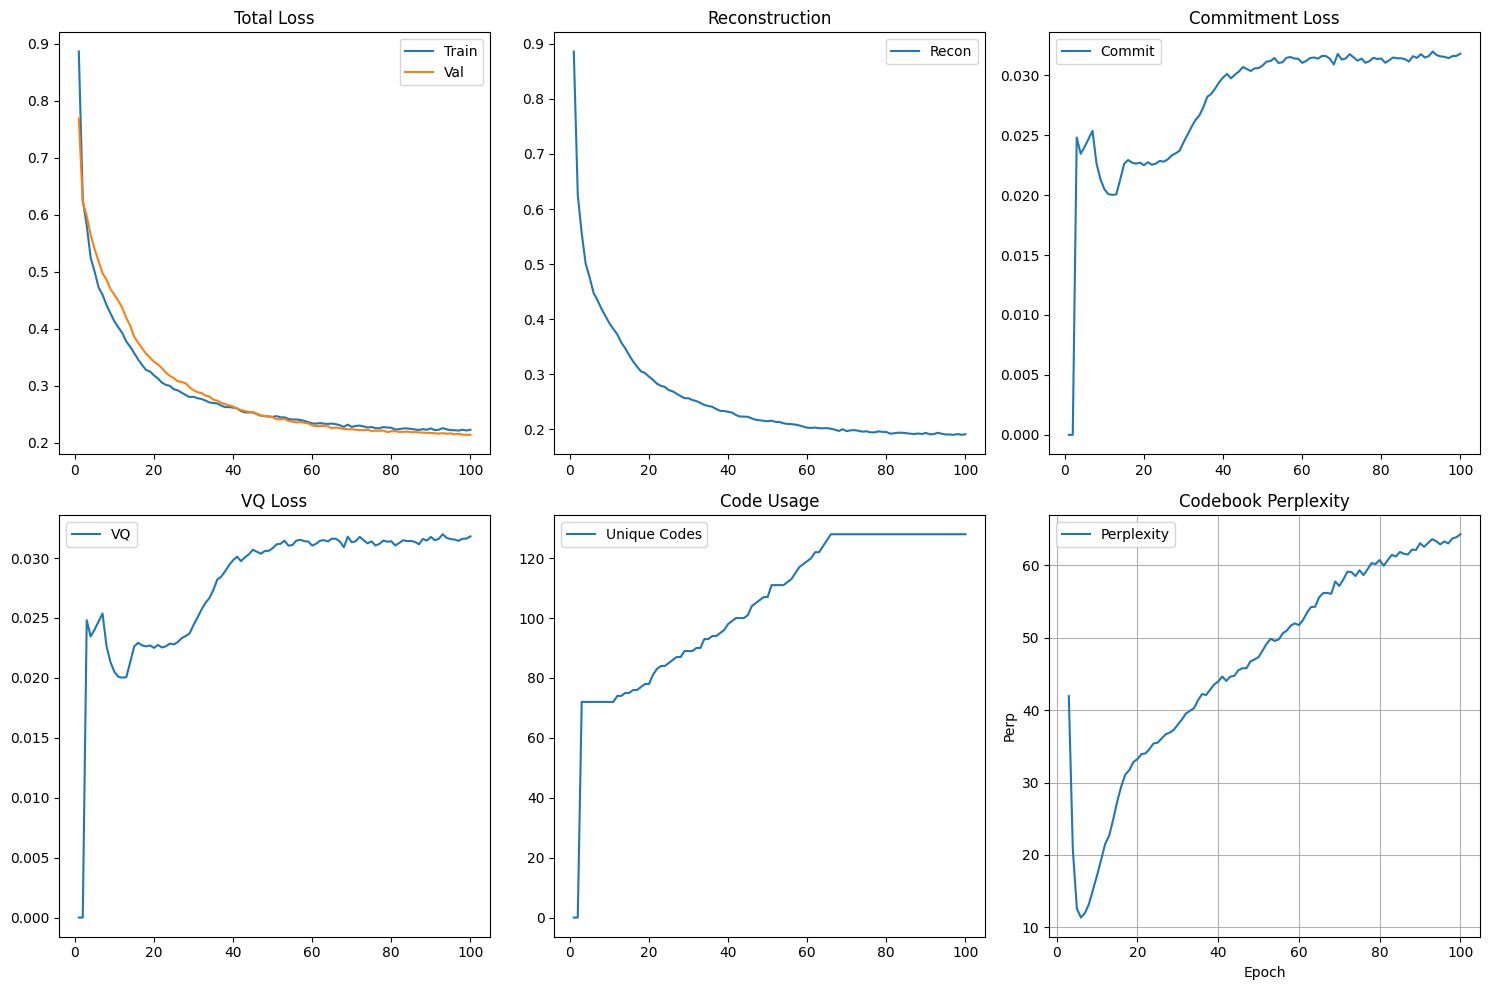

In [15]:
train_vqvae(model, train_loader, val_loader, optimizer, epochs=100, noise_std=0.05)

In [16]:
torch.save(model.state_dict(), "model pt files/vqvae_model.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_model.pth")

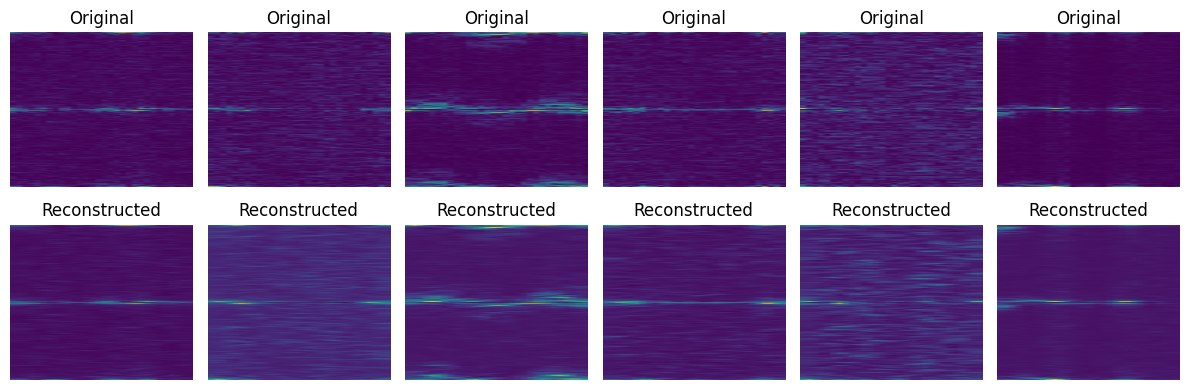

In [17]:
# Define the model again (same config as used during training)
# model = VQVAE(beta=0.75, embedding_dim=32, num_embeddings=128, decay=0.95)
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))
model.eval()
model.to(device)

# Get a batch from the validation loader
device = next(model.parameters()).device
val_iter = iter(test_loader)
batch = next(val_iter).to(device)

# Run the model
with torch.no_grad():
    output = model(batch)
    recon = output["recon_x"]

# Plot original and reconstructed images
n = min(6, batch.size(0))  # number of samples to show
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(batch[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.savefig("output_images/ReconstructionExamples.png")
plt.show()

# Average Latent Space Representation

In [18]:
def validate_chunks(chunks):
    for i, chunk in enumerate(chunks):
        if chunk['exp_no'].nunique() != 1 or chunk['activity'].nunique() != 1:
            raise ValueError(f"Chunk {i} contains multiple exp_no or activity values.")
    print("All chunks have consistent 'exp_no' and 'activity'.")

In [19]:
def sample_chunks_by_activity(chunks, n_per_activity=5, seed=2555304):
    random.seed(seed)
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    sampled_chunks = []
    for activity, chunk_list in activity_map.items():
        sampled = random.sample(chunk_list, min(n_per_activity, len(chunk_list)))
        sampled_chunks.extend(sampled)
    return sampled_chunks

In [20]:
def chunk_to_image(chunk, channel='PWR_ch1'):
    # Safely reshape each (200,) array to (200, 1), then stack horizontally
    images = [arr.reshape(200, 1) for arr in chunk[channel].values]
    return np.hstack(images)  # Result: (200, 80)

In [21]:
def plot_chunks_as_images(chunks, cmap='inferno'):
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    for activity, chunk_list in activity_map.items():
        n = len(chunk_list)
        cols = 5
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(4 * cols, 3 * rows))

        for i, chunk in enumerate(chunk_list):
            img = chunk_to_image(chunk)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, aspect='auto', cmap=cmap, origin='lower')
            plt.title(f"{activity} #{i+1}")
            plt.axis('off')

        plt.suptitle(f"Activity: {activity}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig("output_images/Sampled Images.png")
        plt.show()


In [22]:
# Validate all chunks
validate_chunks(chunks)

All chunks have consistent 'exp_no' and 'activity'.


In [23]:
# Sample 5 chunks per activity
sampled_chunks = sample_chunks_by_activity(chunks, n_per_activity=5)

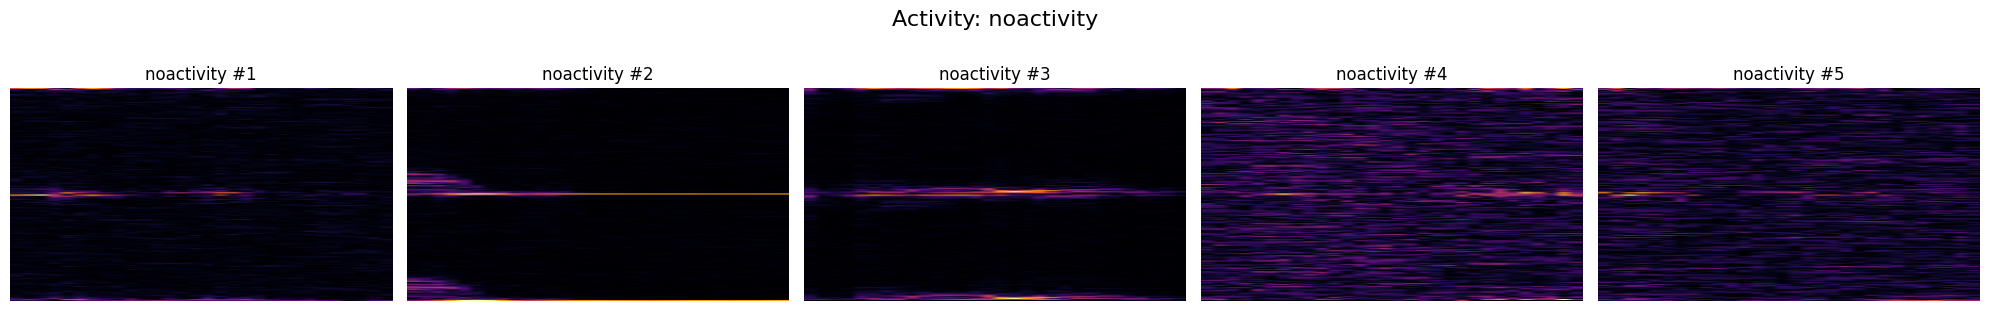

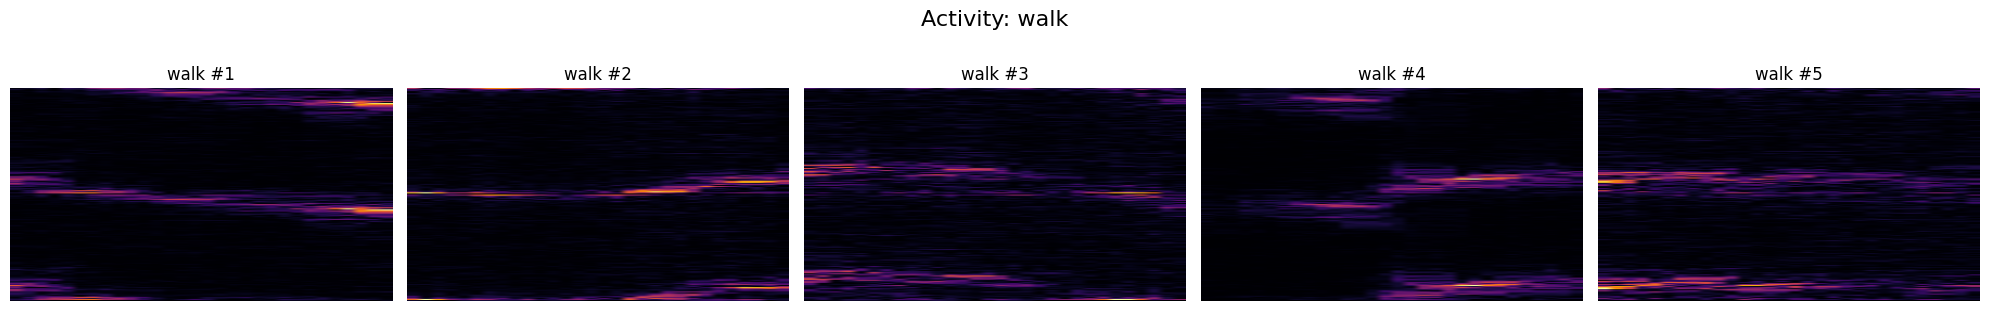

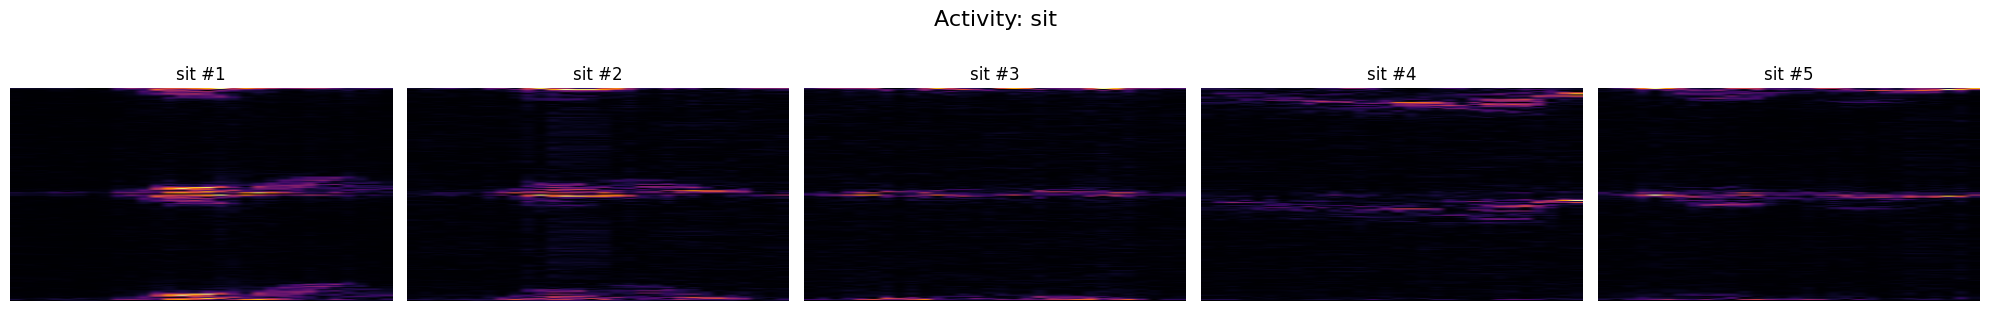

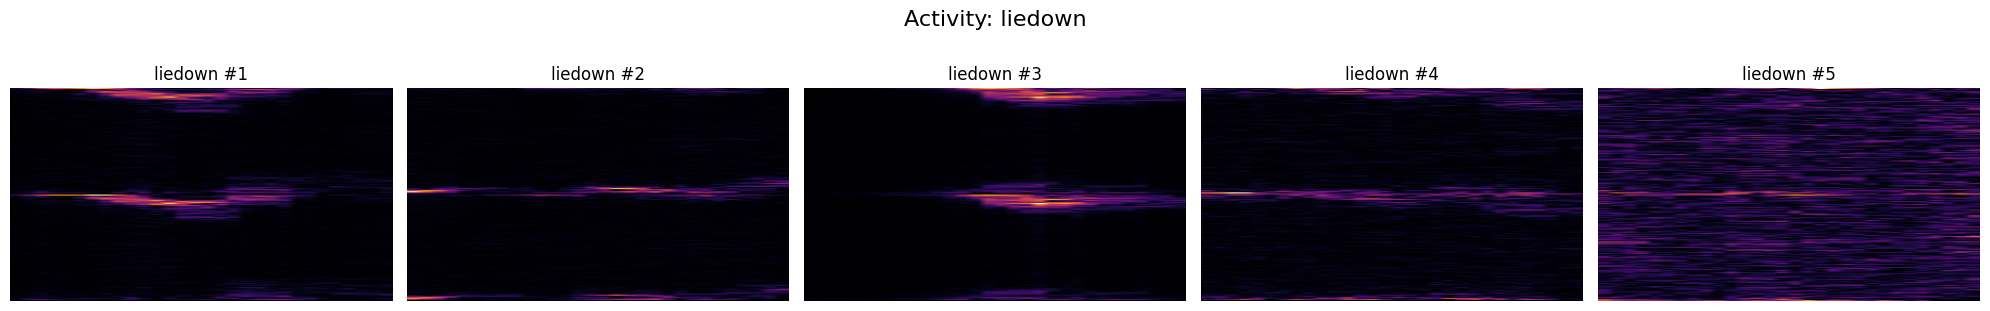

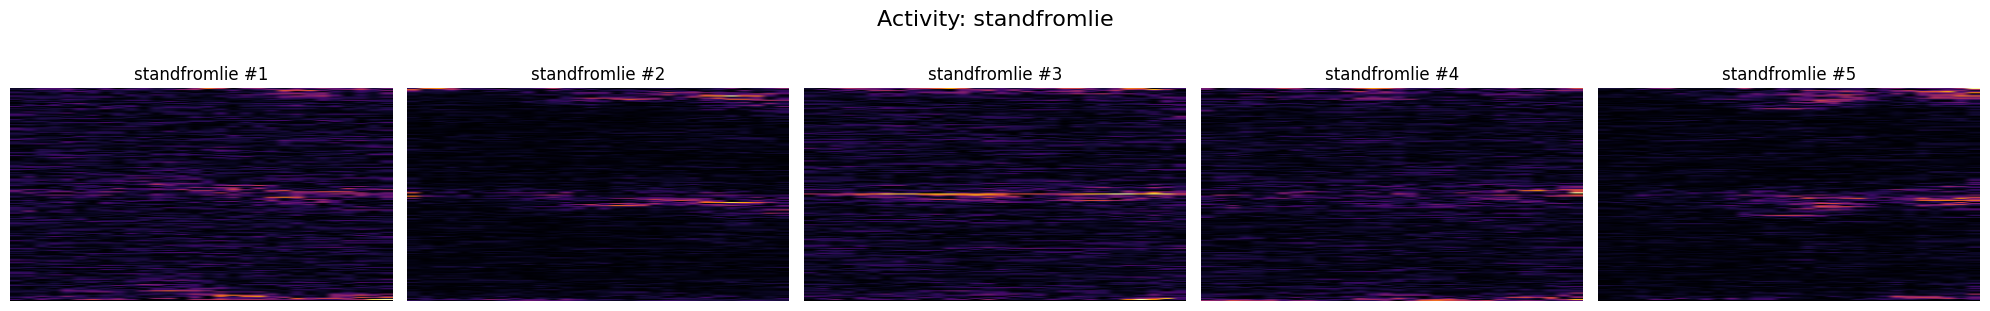

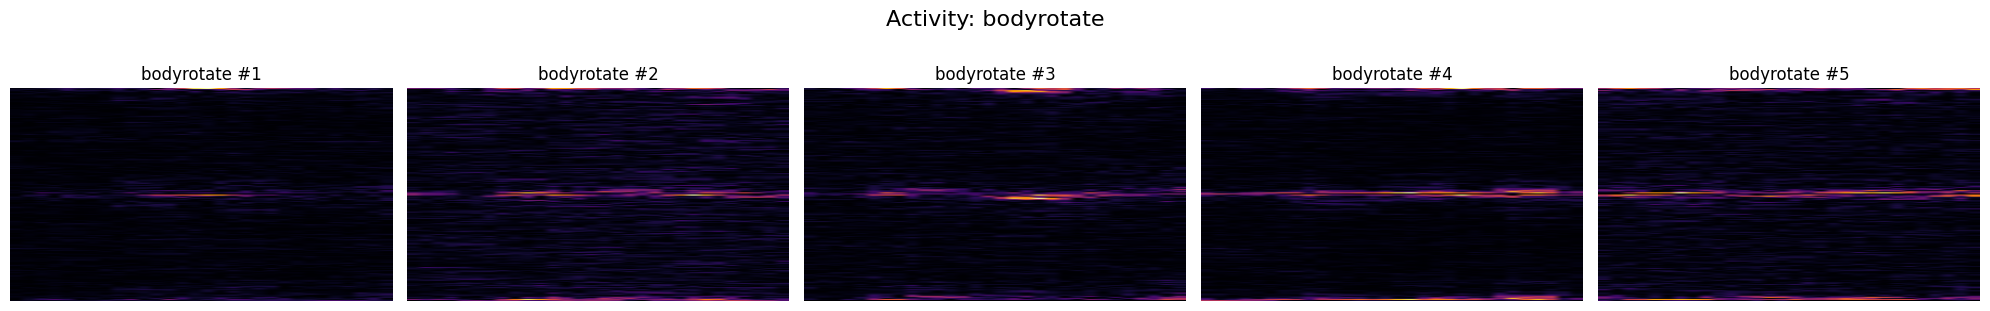

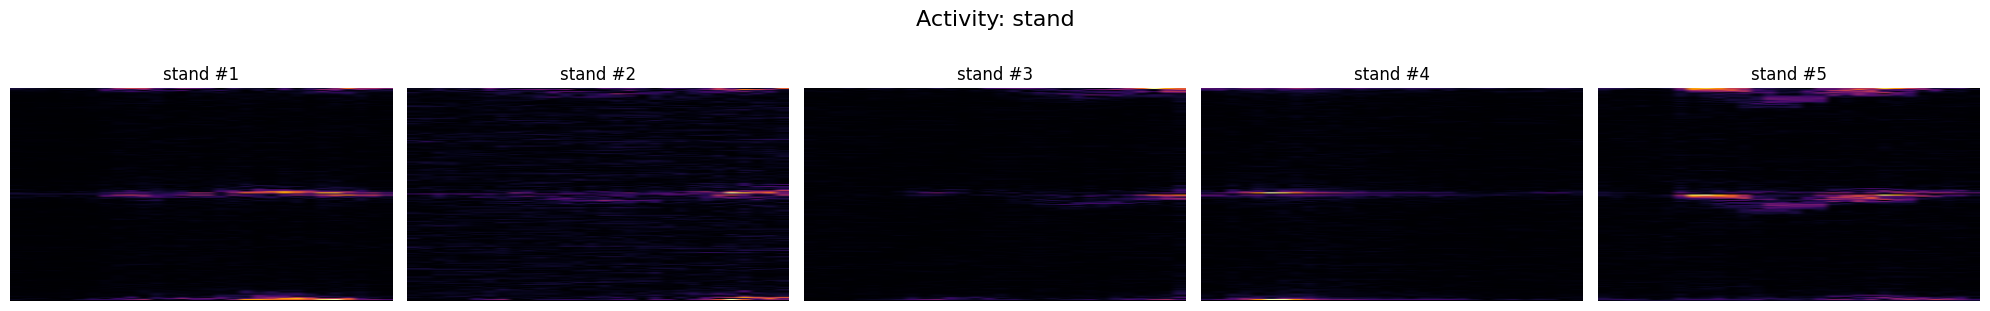

In [24]:
# Plot as images
plot_chunks_as_images(sampled_chunks)

In [25]:
def count_chunks_by_activity(chunks):
    activity_counts = Counter(chunk['activity'].iloc[0] for chunk in chunks)
    return activity_counts

In [26]:
activity_counts = count_chunks_by_activity(chunks)

for activity, count in activity_counts.items():
    print(f"{activity}: {count} chunks")

noactivity: 4048 chunks
walk: 1149 chunks
sit: 54 chunks
liedown: 194 chunks
standfromlie: 189 chunks
bodyrotate: 763 chunks
stand: 37 chunks


In [27]:
def filter_out_class(chunks, class_to_remove='noactivity'):
    return [chunk for chunk in chunks if chunk['activity'].iloc[0] != class_to_remove]

chunks = filter_out_class(chunks, class_to_remove='noactivity')

In [37]:
def encode_chunks(model, chunks, device, mode="z_q", batch_size=128):
    model.eval()
    X, y = [], []
    with torch.no_grad():
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i+batch_size]
            imgs, labs = [], []
            for df in batch:
                labs.append(df["activity"].iat[0])
                img = np.stack(df["PWR_ch1"].to_numpy()).astype(np.float32).T[None, None, ...]
                imgs.append(img)
            xb = torch.from_numpy(np.concatenate(imgs, 0)).to(device)
            out = model(xb, quantize=(mode=="z_q"))
            z   = out["z_q"]                               # [B,C,H,W]
            m, s = z.mean((2,3)), z.std((2,3))
            z_vec = F.normalize(torch.cat([m, s], 1), p=2, dim=1)   # [B,2C]
            X.append(z_vec.cpu().numpy())
            y += labs
    return np.concatenate(X, 0), np.array(y)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr

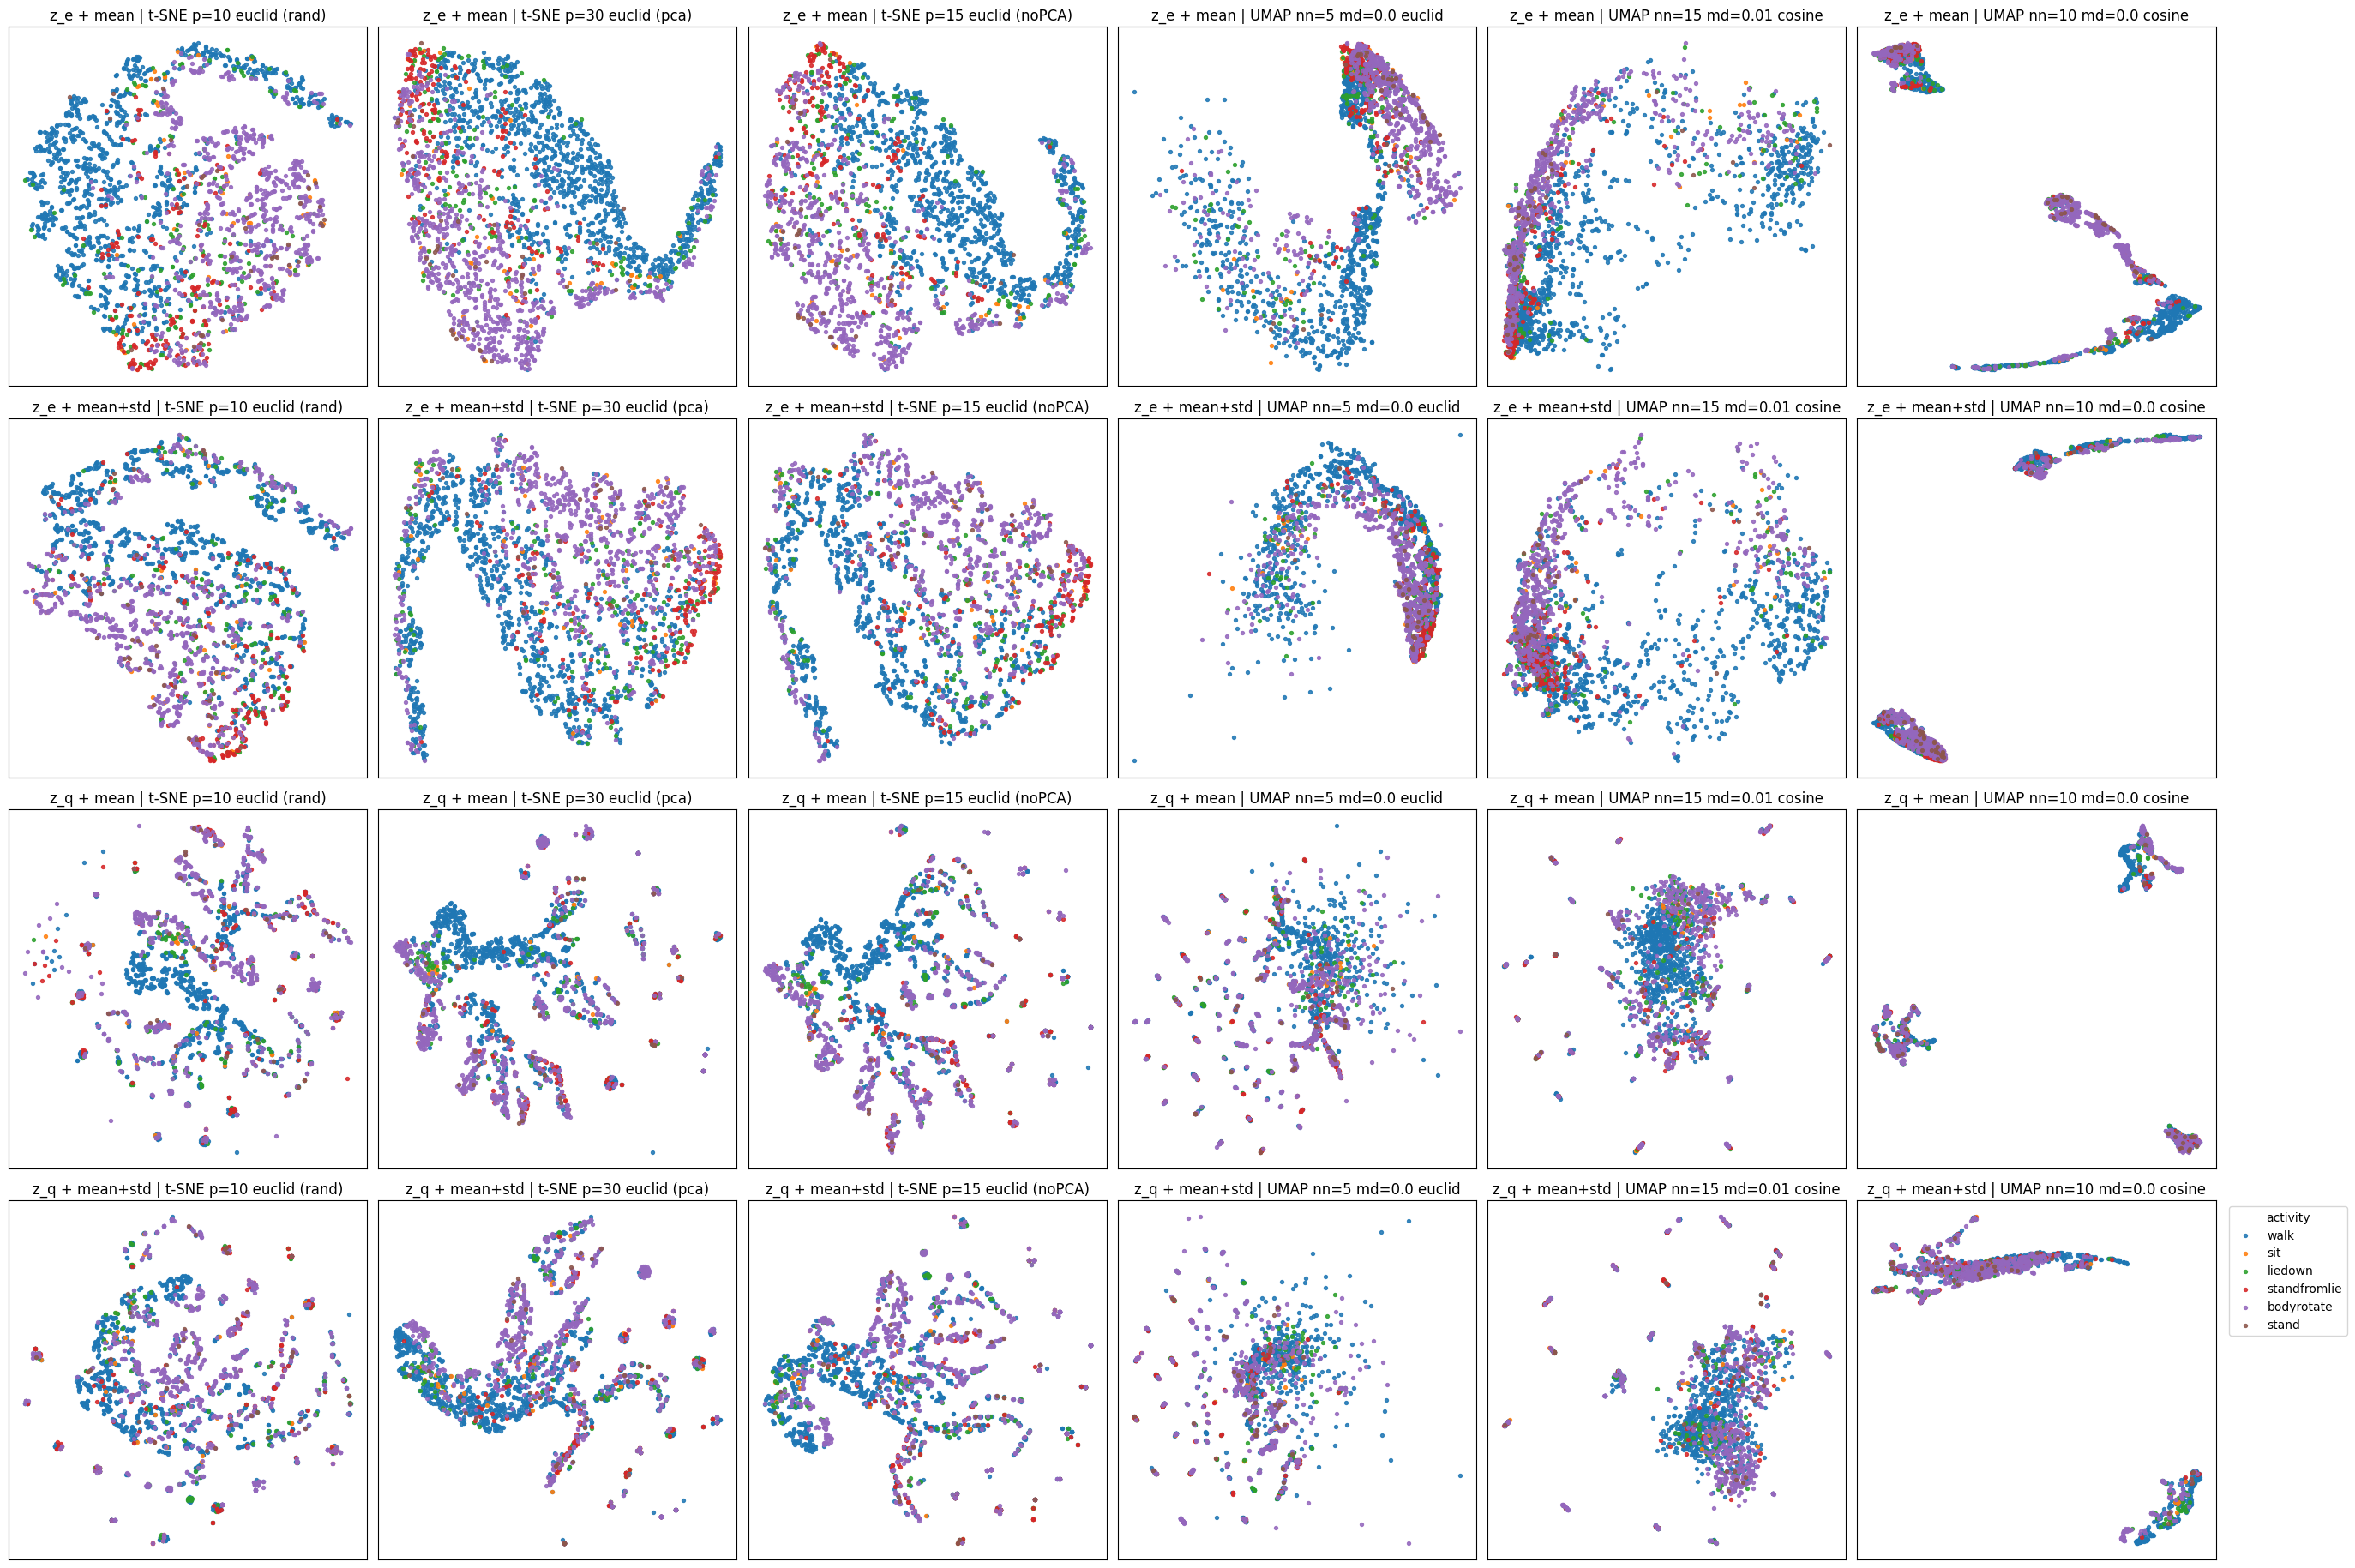

In [45]:
# ---------------- helpers ----------------
def pool_feats(z, mean_only=False):
    """z: [B,C,H,W] -> [B,D] (L2 normalized)."""
    m = z.mean((2,3))
    if mean_only:
        return F.normalize(m, p=2, dim=1)
    s = z.std((2,3))
    return F.normalize(torch.cat([m, s], dim=1), p=2, dim=1)

@torch.no_grad()
def encode_chunks(model, chunks, device, mode="z_q", mean_only=False, batch_size=128):
    """
    mode: 'z_q' (quantized) or 'z_e' (pre-quantization).
          For 'z_e', we run encoder->quant_proj->quant_ln and STOP (no quantizer).
    """
    model.eval()
    X, y = [], []
    for i in range(0, len(chunks), batch_size):
        part = chunks[i:i+batch_size]
        imgs, labs = [], []
        for df in part:
            labs.append(df["activity"].iat[0])
            img = np.stack(df["PWR_ch1"].to_numpy()).astype(np.float32).T[None, None, ...]
            imgs.append(img)
        xb = torch.from_numpy(np.concatenate(imgs, 0)).to(device, non_blocking=True)

        if mode == "z_q":
            out = model(xb, quantize=True)
            z = out["z_q"]  # [B,C,H,W]
        else:  # z_e: replicate your forward's pre-quant steps
            ze = model.encoder(xb)
            ze = model.quant_proj(ze)
            B, D, H, W = ze.shape
            z_flat = ze.permute(0,2,3,1).reshape(-1, D)
            z_flat = model.quant_ln(z_flat)
            z = z_flat.view(B, H, W, D).permute(0,3,1,2).contiguous()  # [B,D,H,W]

        X.append(pool_feats(z, mean_only=mean_only).cpu().numpy())
        y += labs
    return np.concatenate(X, 0), np.array(y)

def run_tsne(X, seed=2555304, **cfg):
    return TSNE(n_components=2, random_state=seed, **cfg).fit_transform(X)

def run_umap(X, seed=2555304, **cfg):
    reducer = umap.UMAP(random_state=seed, **cfg)
    return reducer.fit_transform(X)

# ---------------- configs ----------------
# columns (label, reducer_fn, use_pca, kwargs)
PANELS = [
    ("t-SNE p=10 euclid (rand)",  run_tsne, True,  dict(perplexity=10, metric="euclidean", init="random", early_exaggeration=20, learning_rate="auto")),
    ("t-SNE p=30 euclid (pca)",   run_tsne, True,  dict(perplexity=30, metric="euclidean", init="pca",    learning_rate="auto")),
    ("t-SNE p=15 euclid (noPCA)", run_tsne, False, dict(perplexity=15, metric="euclidean", init="pca",    learning_rate="auto")),
    ("UMAP nn=5 md=0.0 euclid",   run_umap, True,  dict(n_neighbors=5,  min_dist=0.0,  metric="euclidean", densmap=True)),
    ("UMAP nn=15 md=0.01 cosine", run_umap, True,  dict(n_neighbors=15, min_dist=0.01, metric="cosine",    densmap=True)),
    ("UMAP nn=10 md=0.0 cosine",  run_umap, False, dict(n_neighbors=10, min_dist=0.0,  metric="cosine",    densmap=False)),
]

# rows: (name_for_row, mode, mean_only)
ROWS = [
    ("z_e + mean",        "z_e", False),   # mean of pre-quant latents
    ("z_e + mean+std",    "z_e", True),    # (note: we’ll flip meaning below to show both)
    ("z_q + mean",        "z_q", False),   # mean of quantized latents
    ("z_q + mean+std",    "z_q", True),
]
# NB: encode_chunks(mean_only=False) = mean+std, mean_only=True = mean-only.
# Flip the booleans in ROWS if you prefer different ordering labels.

# --------------- run encodings (once per row) ---------------
# (This keeps computations reasonable even for large chunk sets.)
encodings = {}
uniq_acts = list(dict.fromkeys([df["activity"].iat[0] for df in chunks]))
for row_name, mode, is_meanstd in ROWS:
    X, lab = encode_chunks(model, chunks, device, mode=mode, mean_only=is_meanstd, batch_size=128)
    encodings[row_name] = (X, lab)

# consistent colors
labels_all = next(iter(encodings.values()))[1]
uniq = list(dict.fromkeys(labels_all))
act2idx = {a:i for i,a in enumerate(uniq)}

# --------------- plotting grid ---------------
cols = len(PANELS)
rows = len(ROWS)
plt.figure(figsize=(5.2*cols, 4.6*rows))

for r, (row_name, _, _) in enumerate(ROWS):
    X, labels = encodings[row_name]
    # PCA (shared per-row so panels are comparable)
    n_pca = min(100, X.shape[1])
    X_pca = PCA(n_components=n_pca, random_state=2555304).fit_transform(X)

    for c, (title, fn, use_pca, cfg) in enumerate(PANELS):
        plt.subplot(rows, cols, r*cols + c + 1)
        X_in = X_pca if use_pca else X
        emb = fn(X_in, **cfg)

        for a in uniq:
            mask = (labels == a)
            plt.scatter(emb[mask,0], emb[mask,1], s=8, alpha=0.85, label=a)
        plt.title(f"{row_name} | {title}")
        plt.xticks([]); plt.yticks([])

# single shared legend
handles, labs = plt.gca().get_legend_handles_labels()
dedup = dict(zip(labs, handles))
plt.legend(dedup.values(), dedup.keys(), title="activity",
           bbox_to_anchor=(1.02, 1.0), loc="upper left", frameon=True)

plt.tight_layout()
plt.subplots_adjust(right=0.83)
plt.savefig("/content/drive/MyDrive/latent_grid_ze_zq_pooling.png", dpi=220)
plt.show()

In [46]:
# X_lat: pooled+L2 latents you already built
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
y = np.array(y_lab)
knn = KNeighborsClassifier(n_neighbors=15, metric='cosine')
print(cross_val_score(knn, X_lat, y, cv=5).mean())


0.4598045665464944


In [47]:
# after mean+std pool + L2
acc_z = cross_val_score(KNeighborsClassifier(n_neighbors=15, metric='cosine'),
                         X_lat, np.array(y_lab), cv=5).mean()
print(acc_z)


0.4598045665464944
